##### Section (4.1 Master Dark)

In [1]:
#Cell 1

# Importing necessary libraries for all parts of the lab 
import numpy as np
# Provides support for large, multi-dimensional arrays and matrices.
# Useful for mathematical operations such as those needed for constructing master darks, median calculations, and image subtraction.
from scipy import stats
# Help with tasks like calculating the median or other statistical properties of the data.
from scipy.stats import norm

from astropy.io import fits
# This is used to read and write FITS (Flexible Image Transport System) files, which is the standard format for astronomical data.
# Essential for loading the images, spectra, flat-fields, and dark frames into Python for further analysis.
from astropy.modeling import models, fitting
# Provides a framework for defining models and fitting them to data.
# Useful for tasks like wavelength calibration, where fitting a model to arc lamp spectra is needed.
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

import matplotlib.pyplot as plt
# A plotting library for creating visualizations such as spectra, fitted curves, and other data representations.
from numpy.polynomial import Polynomial
# Helps with creating and manipulating polynomial functions.
# Useful for tasks like fitting a polynomial to wavelength solutions or correcting for any distortions in the data.
from scipy.signal import find_peaks

import os


import astropy
astropy.__path__

import keyring
keyring.set_password('astroquery:astrometry_net', None, 'apikeyhere')
from astroquery.astrometry_net import AstrometryNet

from photutils.segmentation import SourceCatalog, detect_sources
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import simple_norm

from astropy.convolution import convolve, Gaussian2DKernel

In [2]:
# Cell 2

# 4.1
def read_fits_range(file_template, start_idx, end_idx):
    """
    Read a range of FITS files based on the template and indices.

    :param file_template: Template path for the FITS files with placeholders for the frame number.
    :type file_template: str
    :param start_idx: The starting index for the FITS files.
    :type start_idx: int
    :param end_idx: The ending index for the FITS files.
    :type end_idx: int
    :return: A list of tuples containing headers and data for each FITS file.
    :rtype: list of tuples
    """
    frames_info = []
    # Initializes an empty list to store tuples containing the header and data of each FITS file.
    for i in range(start_idx, end_idx + 1):
        # Iterates through the specified range of indices
        file_path = file_template.format(i)
        # Uses the template to create the file path for each FITS file by inserting the current index i into the placeholder.
        with fits.open(file_path) as hdul:
            # Opens the FITS file using astropy.io.fits. The with statement ensures that the file is properly closed after reading.
            # hdul (HDU list) is an object containing all the data and metadata from the FITS file.
            header = hdul[0].header
            # Extracts （提取） the header from the primary HDU (Header Data Unit).
            data = hdul[0].data
            # Extracts the image data from the primary HDU
            frames_info.append((header, data))
            # Adds a tuple containing the header and data of the current FITS file to the frames_info list.
    return frames_info # Returns a list of tuples, where each tuple represents a FITS file’s header and data.

# Allows to load multiple images quickly and efficiently, making it easier to compute the median of a series of images.

In [3]:
# Cell 3

def Nov_5_DY_Peg_read_calibration_fits(bias_frame_template, bias_frame_start_index, bias_frame_end_index,
                          dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index,
                          dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index,
                          light_frame_template, light_frame_start_index, light_frame_end_index,
                          flat_frame_template, flat_frame_start_index, flat_frame_end_index):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and mercury arc lamp spectrum.

    :param bias_file_template: Template path for the bias frames with placeholders for the frame number.
    :type bias_file_template: str
    :param bias_start_index: The starting index for the bias frames.
    :type bias_start_index: int
    :param bias_end_index: The ending index for the bias frames.
    :type bias_end_index: int
    :param dark_file_template: Template path for the dark frames with placeholders for the frame number.
    :type dark_file_template: str
    :param dark_start_index: The starting index for the dark frames.
    :type dark_start_index: int
    :param dark_end_index: The ending index for the dark frames.
    :type dark_end_index: int
    :param flat_file_template: Template path for the flat field frames with placeholders for the frame number.
    :type flat_file_template: str
    :param arc_lamp_file_template: Template path for the mercury arc lamp spectrum frames with placeholders for the frame number.
    :type arc_lamp_file_template: str
    :param start_index: The starting index for both the flat fields and mercury arc lamp spectrum frames.
    :type start_index: int
    :param end_index: The ending index for both the flat fields and mercury arc lamp spectrum frames.
    :type end_index: int
    :return: A tuple containing lists of headers and data for bias frames, dark frames, flat fields, and arc lamp spectrum.
    :rtype: tuple (list of tuples, list of tuples, list of tuples, list of tuples)
    """
    bias_frames = read_fits_range(bias_frame_template, bias_frame_start_index, bias_frame_end_index)
    dark_frame_light = read_fits_range(dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index)
    dark_frame_flat = read_fits_range(dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index)
    light_frame = read_fits_range(light_frame_template, light_frame_start_index, light_frame_end_index)
    flat_frame = read_fits_range(flat_frame_template, flat_frame_start_index, flat_frame_end_index)

    return bias_frames, dark_frame_light, dark_frame_flat, light_frame, flat_frame

# Templates for the file names

bias_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Bias_Frames_.{:08d}.BIAS.FIT"
dark_frame_light_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Dark_Frames_.{:08d}.DARK.FIT"
dark_frame_flat_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Dark_Frames_FOR_Flat_Fields_ONLY_.{:08d}.DARK.FIT"
light_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Light_Frames_.{:08d}.FIT"
flat_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Flat_Fields_.{:08d}.FLAT.FIT"


# Define the starting and ending indices


bias_frame_start_index = 0
bias_frame_end_index = 9
dark_frame_light_start_index = 0
dark_frame_light_end_index = 9
dark_frame_flat_start_index = 0
dark_frame_flat_end_index = 9
light_frame_start_index = 0
light_frame_end_index = 240  # For further analysis, ignore frames 67 to 71, and 122
flat_frame_start_index = 8 
flat_frame_end_index = 17




# Calling the function
bias_frames, dark_frame_light, dark_frame_flat, light_frame, flat_frame = Nov_5_DY_Peg_read_calibration_fits(
    bias_frame_template, bias_frame_start_index, bias_frame_end_index,
    dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index,
    dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index,
    light_frame_template, light_frame_start_index, light_frame_end_index,
    flat_frame_template, flat_frame_start_index, flat_frame_end_index
)


# This function is crucial for the initial data reduction steps:

# Step 1: Reading in dark frames and constructing master darks.
# Step 2: Preparing calibration frames (dark, bias, flat, and arc spectra) for subtraction and correction of science data.
# Step 3: Reading flat fields to create a master flat.
# Step 4: Preparing the arc lamp spectra for wavelength calibration.


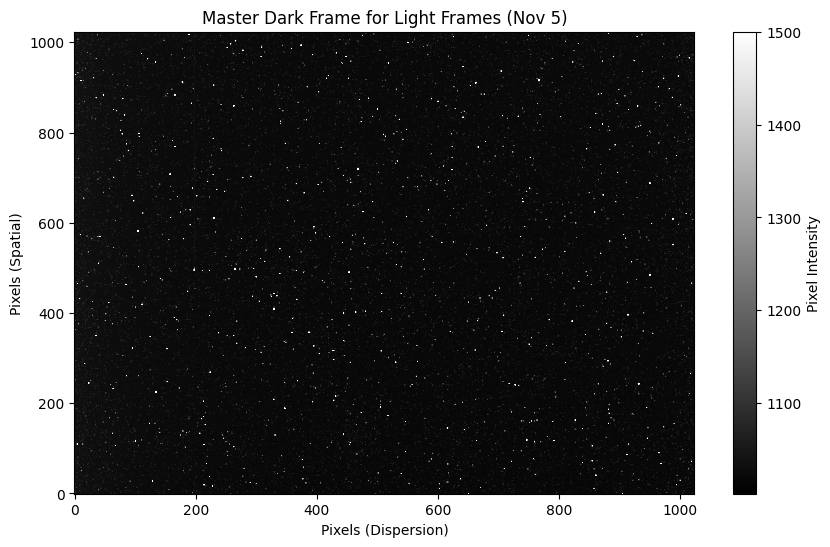

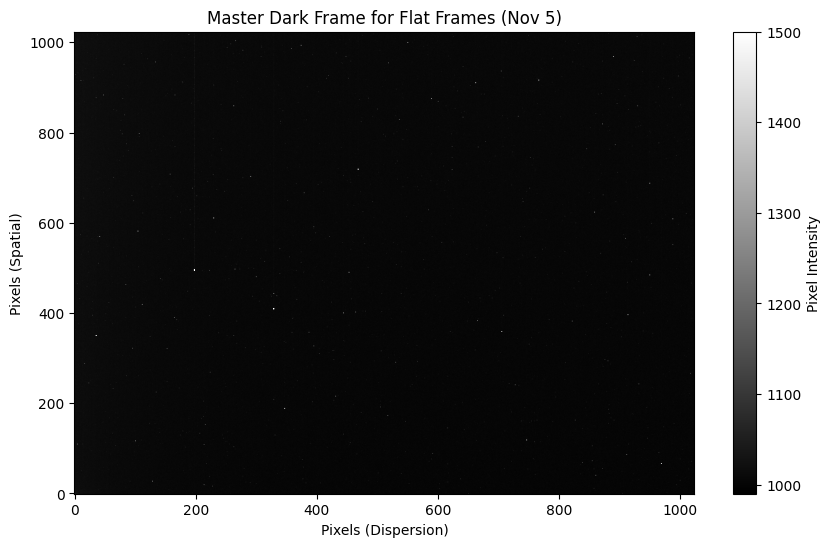

In [36]:
# Cell 4

def create_master_dark(dark_frame_light_template, dark_frame_flat_template):
    """
    Create a master dark frame by median-combining the dark frames, and output the graph of the master 
    dark field with a maximum value of 9000.

    :param dark_frames: List of tuples containing headers and data for the dark FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type dark_frames: list of tuples
    :return: Master dark frame after bias subtraction.
    :rtype: np.ndarray
    """

    # dark_frames: A list of tuples containing headers and data for each dark frame. 
    # Each tuple has a FITS header and a 2D numpy array (data).
    # Create the master dark frame by median-combining the dark frames
    dark_light_data_list = [frame[1] for frame in dark_frame_light_template]  # Extract the 'data' part from each dark frame
    dark_flat_data_list = [frame[1] for frame in dark_frame_flat_template]
    master_dark_l = np.median(np.array(dark_light_data_list), axis=0)
    master_dark_f = np.median(np.array(dark_flat_data_list), axis=0)


#array

    # Extracts the data (2D numpy arrays) from each tuple in dark_frames.
    # Stacks these arrays into a 3D array using np.stack and calculates the median across the stack along the specified axis (axis=0), 
    # which computes the median for each pixel.
    # This process effectively reduces random noise and outliers, such as cosmic ray hits, in the combined master dark frame.

    # Filter the master dark frame
    # master_dark_l[master_dark_l > 9000] = 9000  
    # Clamp values above 9000
    # master_dark_f[master_dark_f > 9000] = 9000
    # Plotting the master dark frame with a maximum value of 9000
    

    # Plotting the master dark for light frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_l, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Light Frames (Nov 5)')
    plt.grid(False)
    plt.show()
    
    # Plotting the master dark for flat frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_f, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Flat Frames (Nov 5)')
    plt.grid(False)
    plt.show()

    return master_dark_l, master_dark_f


# Example call to the function after loading data correctly

# Load the dark frames using read_fits_range
dark_frame_light = read_fits_range(dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index)
dark_frame_flat = read_fits_range(dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index)

master_dark_l, master_dark_f = create_master_dark(dark_frame_light, dark_frame_flat)


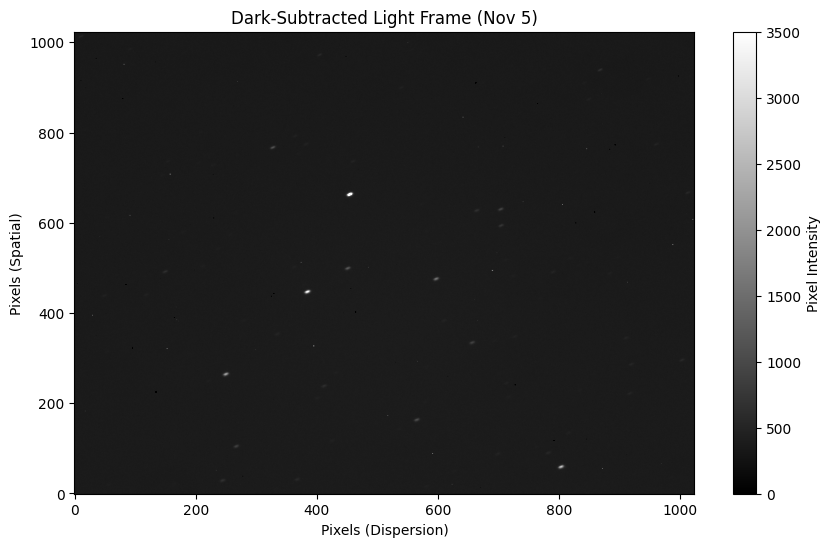

Master Dark Min: 1002.5, Max: 62215.0
Light Frame (Before Subtraction) Min: 1299, Max: 62566
Light Frame (After Subtraction) Min: -13804.0, Max: 7566.0


In [39]:
# Cell 5

def subtract_master_dark(frames, master_dark): #, clip_min=0):
    """
    Subtract the master dark frame from each frame in a list of FITS frames and optionally clip negative values.

    :param frames: List of tuples containing headers and data for each FITS frame (light or flat frames).
                   Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type frames: list of tuples
    :param master_dark: Master dark frame to subtract from each frame's data.
    :type master_dark: np.ndarray
    :param clip_min: Minimum value for pixel intensity to avoid negative values (default is 0).
    :type clip_min: float
    :return: List of tuples with headers and dark-subtracted (and optionally clipped) data for each frame.
    :rtype: list of tuples
    """
    subtracted_frames = []
    for header, data in frames:
        # Perform dark subtraction
        subtracted_data = data - master_dark
        
        # Clip values below clip_min
        # subtracted_data = np.maximum(subtracted_data, clip_min)
        
        subtracted_frames.append((header, subtracted_data))
    return subtracted_frames


# Load the light and flat frames
light_frames = read_fits_range(light_frame_template, light_frame_start_index, light_frame_end_index)
flat_frames = read_fits_range(flat_frame_template, flat_frame_start_index, flat_frame_end_index)

# Subtract the master dark frames and clip negatives to 0
light_frames_dark_subtracted = subtract_master_dark(light_frames, master_dark_l) #, clip_min=0)
flat_frames_dark_subtracted = subtract_master_dark(flat_frames, master_dark_f) #, clip_min=0)

# Visualize the dark-subtracted light frame
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_dark_subtracted[5][1], cmap='gray', origin='lower', aspect='auto', vmax=3500, vmin=0)
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Dark-Subtracted Light Frame (Nov 5)')
plt.grid(False)
plt.show()

# Debugging: Inspect the range of pixel values
print(f"Master Dark Min: {master_dark_l.min()}, Max: {master_dark_l.max()}")
print(f"Light Frame (Before Subtraction) Min: {light_frames[0][1].min()}, Max: {light_frames[0][1].max()}")
print(f"Light Frame (After Subtraction) Min: {light_frames_dark_subtracted[0][1].min()}, Max: {light_frames_dark_subtracted[0][1].max()}")


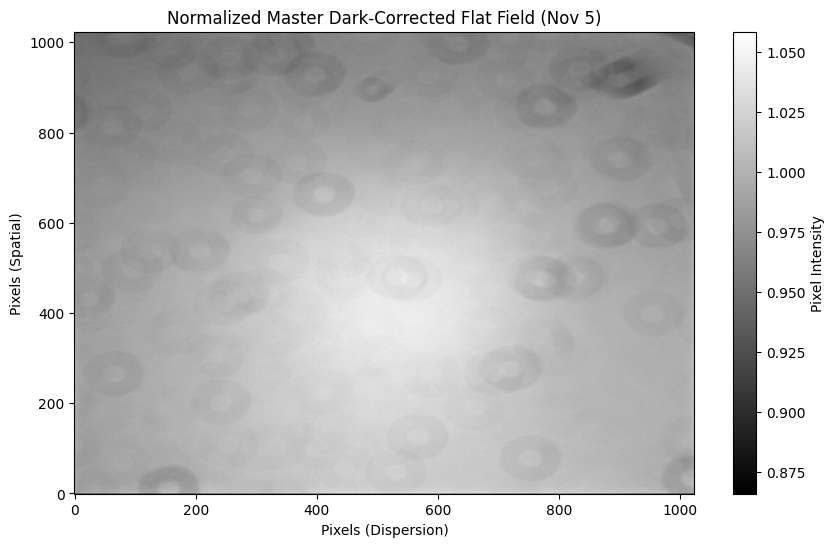

In [11]:
# Cell 6

def dark_corrected_flat(flat_frames_dark_subtracted):
    """
    Plot a dark-corrected and normalized flat field to show the intensity distribution.

    :param flat_frames_dark_subtracted: List of tuples with headers and dark-corrected flat field data.
                                        Each tuple has the format (header, data), where data is a 2D numpy array.
    :type flat_frames_dark_subtracted: list of tuples
    """
    # Directly combine dark-subtracted flat frames to create a master flat
    master_flat = np.median(np.stack([frame[1] for frame in flat_frames_dark_subtracted]), axis=0)

    # Calculate the mode of the master flat's flattened data
    mode_value = stats.mode(master_flat.flatten(), keepdims=True)[0][0]

    # Normalize the master flat by dividing by the mode value
    normalized_master_flat = master_flat / mode_value

    # Plot the normalized master dark-corrected flat field
    plt.figure(figsize=(10, 6))
    plt.imshow(normalized_master_flat, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Normalized Master Dark-Corrected Flat Field (Nov 5)')
    plt.grid(False)
    plt.show()
    
    return normalized_master_flat

# Example call to plot function
normalized_master_flat = dark_corrected_flat(flat_frames_dark_subtracted)


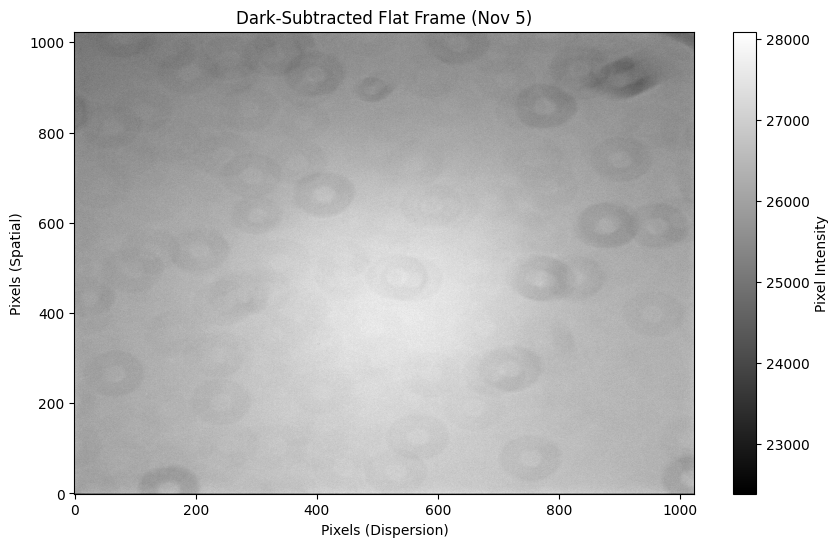

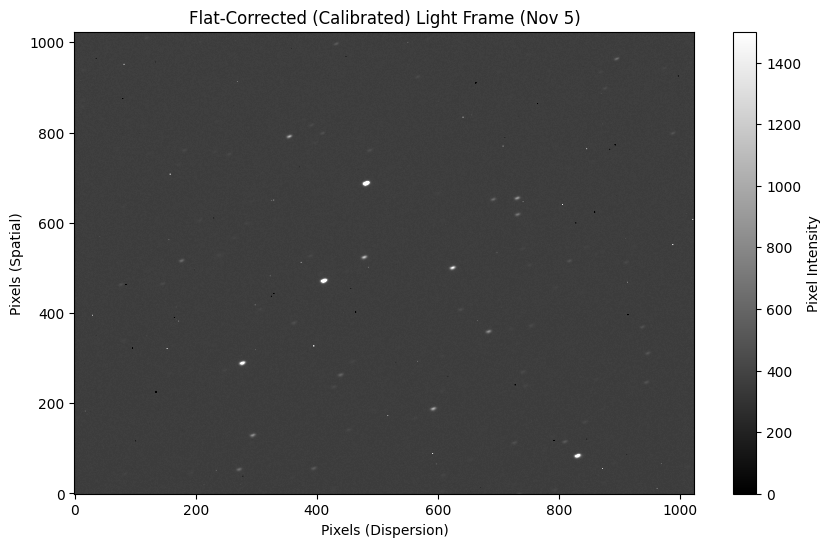

In [ ]:
# Cell 7

def master_flat_light(light_frames_dark_subtracted, master_flat):
    """
    Apply master flat field correction to dark-corrected light frames using a mode-normalized master flat.

    :param light_frames_dark_subtracted: List of tuples with headers and dark-corrected light frame data.
                                         Each tuple has the format (header, data), where data is a 2D numpy array.
    :type light_frames_dark_subtracted: list of tuples
    :param master_flat: Master flat field for flat field correction.
    :type master_flat: np.ndarray
    :return: List of tuples with headers and flat-corrected light frame data.
    :rtype: list of tuples
    """
    

    # Apply the normalized master flat to each dark-corrected light frame
    flat_corrected_frames = []
    for header, data in light_frames_dark_subtracted:
        # Apply flat correction by dividing each pixel by the normalized master flat
        corrected_data = data / normalized_master_flat
        flat_corrected_frames.append((header, corrected_data))
    
    return flat_corrected_frames

# Assuming you've already created the master flat field from the flat frames
flat_frames_dark_subtracted = subtract_master_dark(flat_frames, master_dark_f)
master_flat = np.median([frame[1] for frame in flat_frames_dark_subtracted], axis=0)

# Apply the master flat field to the dark-subtracted light frames
light_frames_flat_corrected = master_flat_light(light_frames_dark_subtracted, master_flat)

# Plot one of the dark-subtracted flat frames
plt.figure(figsize=(10, 6))
plt.imshow(flat_frames_dark_subtracted[0][1], cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Dark-Subtracted Flat Frame (Nov 5)')
plt.grid(False)
plt.show()

# Plot one of the flat-corrected light frames
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_flat_corrected[0][1], cmap='gray', origin='lower', aspect='auto', vmax = 1500)
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Flat-Corrected (Calibrated) Light Frame (Nov 5)')
plt.grid(False)
plt.show()

In [9]:
# Cell 8

def save_flat_corrected_frames_individually(flat_corrected_frames, save_directory=r"..\FITS_Files_Corrected\Nov_5_DY_Peg"):
    
    # Save each flat-corrected light frame as an individual FITS file in the specified directory.

    # :param flat_corrected_frames: List of tuples with headers and flat-corrected light frame data.
                                #  Each tuple has the format (header, data), where `data` is a 2D numpy array.
    # :type flat_corrected_frames: list of tuples
    # :param save_directory: Directory where the individual flat-corrected frames will be saved.
    # :type save_directory: str
    
    # Ensure the save directory exists
    os.makedirs(save_directory, exist_ok=True)
    
    for i, (header, data) in enumerate(flat_corrected_frames):
        # Define the filename for each frame based on its index
        filename = os.path.join(save_directory, f"flat_corrected_frame_{i:04d}.fits")
        
        # Create a new FITS HDU with the corrected data and the original header
        hdu = fits.PrimaryHDU(data=data, header=header)
        
        # Write the FITS file to disk
        hdu.writeto(filename, overwrite=True)
        
        print(f"Saved {filename}")

# Example usage
save_flat_corrected_frames_individually(light_frames_flat_corrected, save_directory=r"..\FITS_Files_Corrected\Nov_5_DY_Peg")


Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0000.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0001.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0002.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0003.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0004.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0005.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0006.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0007.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0008.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0009.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0010.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0011.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0012.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY

In [40]:
# Cell 9

def Nov_7_CY_Aqr_read_calibration_fits(bias_frame_template, bias_frame_start_index, bias_frame_end_index,
                          dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index,
                          dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index,
                          light_frame_template, light_frame_start_index, light_frame_end_index,
                          flat_frame_template, flat_frame_start_index, flat_frame_end_index):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and mercury arc lamp spectrum.

    :param bias_file_template: Template path for the bias frames with placeholders for the frame number.
    :type bias_file_template: str
    :param bias_start_index: The starting index for the bias frames.
    :type bias_start_index: int
    :param bias_end_index: The ending index for the bias frames.
    :type bias_end_index: int
    :param dark_file_template: Template path for the dark frames with placeholders for the frame number.
    :type dark_file_template: str
    :param dark_start_index: The starting index for the dark frames.
    :type dark_start_index: int
    :param dark_end_index: The ending index for the dark frames.
    :type dark_end_index: int
    :param flat_file_template: Template path for the flat field frames with placeholders for the frame number.
    :type flat_file_template: str
    :param arc_lamp_file_template: Template path for the mercury arc lamp spectrum frames with placeholders for the frame number.
    :type arc_lamp_file_template: str
    :param start_index: The starting index for both the flat fields and mercury arc lamp spectrum frames.
    :type start_index: int
    :param end_index: The ending index for both the flat fields and mercury arc lamp spectrum frames.
    :type end_index: int
    :return: A tuple containing lists of headers and data for bias frames, dark frames, flat fields, and arc lamp spectrum.
    :rtype: tuple (list of tuples, list of tuples, list of tuples, list of tuples)
    """
    bias_frames_2 = read_fits_range(bias_frame_template, bias_frame_start_index, bias_frame_end_index)
    dark_frame_light_2 = read_fits_range(dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index)
    dark_frame_flat_2 = read_fits_range(dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index)
    light_frame_2 = read_fits_range(light_frame_template, light_frame_start_index, light_frame_end_index)
    flat_frame_2 = read_fits_range(flat_frame_template, flat_frame_start_index, flat_frame_end_index)

    return bias_frames_2, dark_frame_light_2, dark_frame_flat_2, light_frame_2, flat_frame_2

# Templates for the file names

bias_frame_template_2 = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Bias_Frames_.{:08d}.BIAS.FIT"
dark_frame_light_template_2 = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Dark_Frames_.{:08d}.DARK.FIT"
dark_frame_flat_template_2 = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Dark_Frames_FOR_Flat_Fields_ONLY_.{:08d}.DARK.FIT"
light_frame_template_2 = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Light_Frames_.{:08d}.FIT"
flat_frame_template_2 = r"..\FITS_Files\Nov_7_CY_Aqr\CY_Aqr_Flat_Fields_.{:08d}.FLAT.FIT"


# Define the starting and ending indices


bias_frame_start_index_2 = 0
bias_frame_end_index_2 = 9
dark_frame_light_start_index_2 = 19
dark_frame_light_end_index_2 = 27
dark_frame_flat_start_index_2 = 9
dark_frame_flat_end_index_2 = 18
light_frame_start_index_2 = 0
light_frame_end_index_2 = 199  # For further analysis, ignore frames 67 to 71, and 122
flat_frame_start_index_2 = 0 
flat_frame_end_index_2 = 9




# Calling the function
bias_frames_2, dark_frame_light_2, dark_frame_flat_2, light_frame_2, flat_frame_2 = Nov_7_CY_Aqr_read_calibration_fits(
    bias_frame_template_2, bias_frame_start_index_2, bias_frame_end_index_2,
    dark_frame_light_template_2, dark_frame_light_start_index_2, dark_frame_light_end_index_2,
    dark_frame_flat_template_2, dark_frame_flat_start_index_2, dark_frame_flat_end_index_2,
    light_frame_template_2, light_frame_start_index_2, light_frame_end_index_2,
    flat_frame_template_2, flat_frame_start_index_2, flat_frame_end_index_2
)


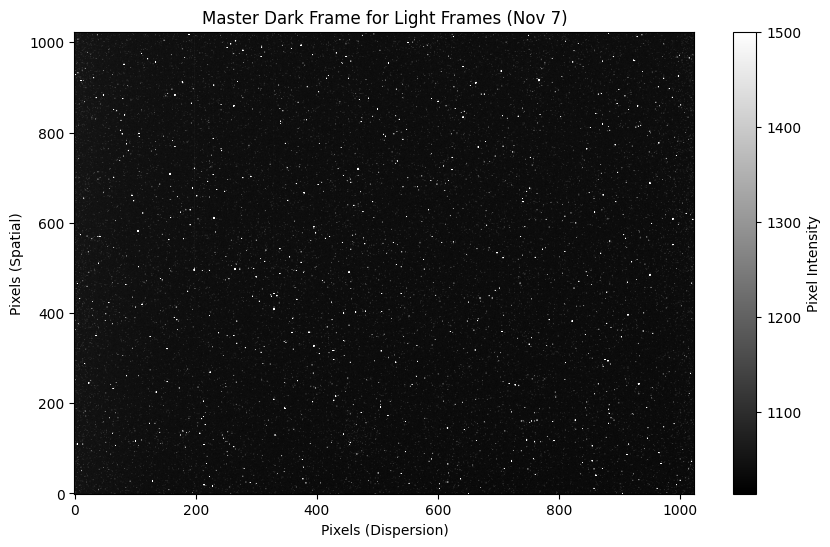

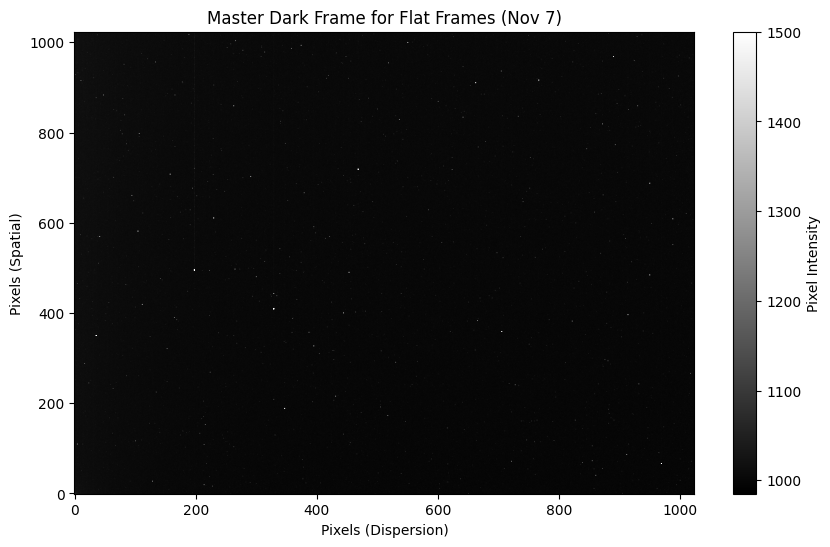

In [41]:
# Cell 10

def create_master_dark(dark_frame_light_template_2, dark_frame_flat_template_2):
    """
    Create a master dark frame by median-combining the dark frames, and output the graph of the master 
    dark field with a maximum value of 9000.

    :param dark_frames: List of tuples containing headers and data for the dark FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type dark_frames: list of tuples
    :return: Master dark frame after bias subtraction.
    :rtype: np.ndarray
    """

    # dark_frames: A list of tuples containing headers and data for each dark frame. 
    # Each tuple has a FITS header and a 2D numpy array (data).
    # Create the master dark frame by median-combining the dark frames
    dark_light_data_list_2 = [frame[1] for frame in dark_frame_light_template_2]  # Extract the 'data' part from each dark frame
    dark_flat_data_list_2 = [frame[1] for frame in dark_frame_flat_template_2]
    master_dark_l_2 = np.median(np.array(dark_light_data_list_2), axis=0)
    master_dark_f_2 = np.median(np.array(dark_flat_data_list_2), axis=0)

    # Extracts the data (2D numpy arrays) from each tuple in dark_frames.
    # Stacks these arrays into a 3D array using np.stack and calculates the median across the stack along the specified axis (axis=0), 
    # which computes the median for each pixel.
    # This process effectively reduces random noise and outliers, such as cosmic ray hits, in the combined master dark frame.

    # Filter the master dark frame
    # master_dark_l[master_dark_l > 9000] = 9000  
    # Clamp values above 9000
    # master_dark_f[master_dark_f > 9000] = 9000
    # Plotting the master dark frame with a maximum value of 9000
    

    # Plotting the master dark for light frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_l_2, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Light Frames (Nov 7)')
    plt.grid(False)
    plt.show()
    
    # Plotting the master dark for flat frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_f_2, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Flat Frames (Nov 7)')
    plt.grid(False)
    plt.show()

    return master_dark_l_2, master_dark_f_2


# Example call to the function after loading data correctly

# Load the dark frames using read_fits_range
dark_frame_light_2 = read_fits_range(dark_frame_light_template_2, dark_frame_light_start_index_2, dark_frame_light_end_index_2)
dark_frame_flat_2 = read_fits_range(dark_frame_flat_template_2, dark_frame_flat_start_index_2, dark_frame_flat_end_index_2)

master_dark_l_2, master_dark_f_2 = create_master_dark(dark_frame_light_2, dark_frame_flat_2)


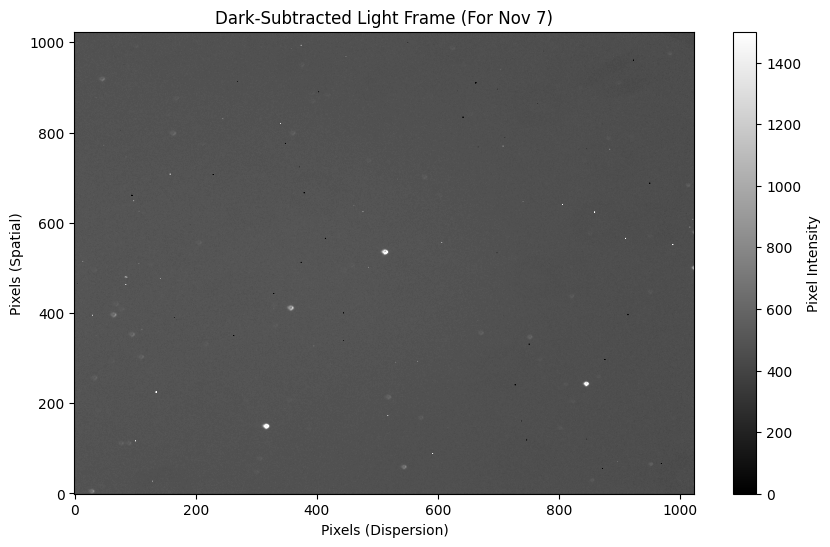

Master Dark Min: 1014.0, Max: 61606.0
Light Frame (Before Subtraction) Min: 1391, Max: 61927
Light Frame (After Subtraction) Min: -11351.0, Max: 14419.0


In [43]:
# Cell 11



def subtract_master_dark(frames, master_dark): #, clip_min=0, clip_max=2000):
    """
    Subtract the master dark frame from each frame in a list of FITS frames and optionally clip negative values.

    :param frames: List of tuples containing headers and data for each FITS frame (light or flat frames).
                   Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type frames: list of tuples
    :param master_dark: Master dark frame to subtract from each frame's data.
    :type master_dark: np.ndarray
    :param clip_min: Minimum value for pixel intensity to avoid negative values (default is 0).
    :type clip_min: float
    :return: List of tuples with headers and dark-subtracted (and optionally clipped) data for each frame.
    :rtype: list of tuples
    """
    subtracted_frames = []
    for header, data in frames:
        # Perform dark subtraction
        subtracted_data = data - master_dark
        
        # Clip values below clip_min
        # subtracted_data = np.maximum(subtracted_data, clip_min)
        
        subtracted_frames.append((header, subtracted_data))
    return subtracted_frames


# Load the light and flat frames
light_frames_2 = read_fits_range(light_frame_template_2, light_frame_start_index_2, light_frame_end_index_2)
flat_frames_2 = read_fits_range(flat_frame_template_2, flat_frame_start_index_2, flat_frame_end_index_2)

# Subtract the master dark frames
light_frames_dark_subtracted_2 = subtract_master_dark(light_frames_2, master_dark_l_2)
flat_frames_dark_subtracted_2 = subtract_master_dark(flat_frames_2, master_dark_f_2)

# Example: Display one of the dark-subtracted light frames
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_dark_subtracted_2[0][1], cmap='gray', origin='lower', aspect='auto', vmin=0, vmax =1500)
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Dark-Subtracted Light Frame (For Nov 7)')
plt.grid(False)
plt.show()

# Debugging: Inspect the range of pixel values
print(f"Master Dark Min: {master_dark_l_2.min()}, Max: {master_dark_l_2.max()}")
print(f"Light Frame (Before Subtraction) Min: {light_frames_2[0][1].min()}, Max: {light_frames_2[0][1].max()}")
print(f"Light Frame (After Subtraction) Min: {light_frames_dark_subtracted_2[0][1].min()}, Max: {light_frames_dark_subtracted_2[0][1].max()}")

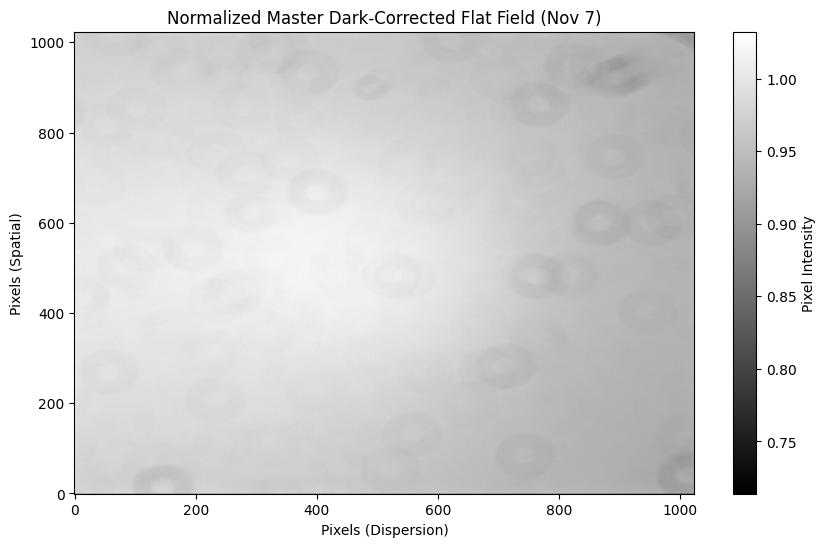

In [22]:
# Cell 12

def dark_corrected_flat_2(flat_frames_dark_subtracted_2):
    """
    Plot a dark-corrected and normalized flat field to show the intensity distribution.

    :param flat_frames_dark_subtracted: List of tuples with headers and dark-corrected flat field data.
                                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type flat_frames_dark_subtracted: list of tuples
    """
    # Directly combine dark-subtracted flat frames to create a master flat
    master_flat_2 = np.median(np.stack([frame[1] for frame in flat_frames_dark_subtracted_2]), axis=0)

    # Calculate the mode of the master flat's flattened data
    mode_value_2 = stats.mode(master_flat_2.flatten(), keepdims=True)[0][0]

    # Normalize the master flat by dividing by the mode value
    normalized_master_flat_2 = master_flat_2 / mode_value_2

    # Plot the normalized master dark-corrected flat field
    plt.figure(figsize=(10, 6))
    plt.imshow(normalized_master_flat_2, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Normalized Master Dark-Corrected Flat Field (Nov 7)')
    plt.grid(False)
    plt.show()
    
    return normalized_master_flat_2

# Example call to plot function
normalized_master_flat_2 = dark_corrected_flat_2(flat_frames_dark_subtracted_2)

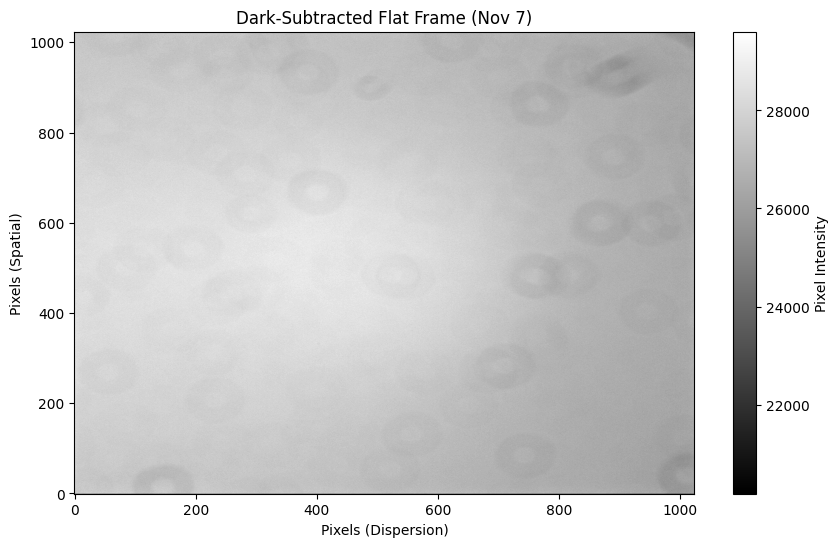

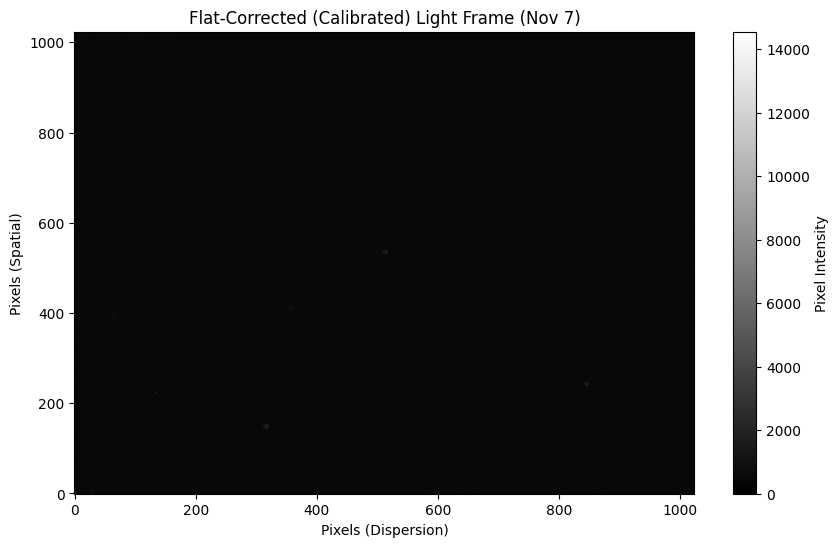

In [23]:
# Cell 13

def master_flat_light(light_frames_dark_subtracted, master_flat):
    """
    Apply master flat field correction to dark-corrected light frames using a mode-normalized master flat.

    :param light_frames_dark_subtracted: List of tuples with headers and dark-corrected light frame data.
                                         Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type light_frames_dark_subtracted: list of tuples
    :param master_flat: Master flat field for flat field correction.
    :type master_flat: np.ndarray
    :return: List of tuples with headers and flat-corrected light frame data.
    :rtype: list of tuples
    """
    # Calculate the mode of the master flat and normalize it
    # mode_value = stats.mode(master_flat.flatten(), keepdims=True)[0][0]
    # normalized_master_flat = master_flat / mode_value

    # Apply the normalized master flat to each dark-corrected light frame
    flat_corrected_frames = []
    for header, data in light_frames_dark_subtracted:
        # Apply flat correction by dividing each pixel by the normalized master flat
        corrected_data = data / normalized_master_flat
        flat_corrected_frames.append((header, corrected_data))
    
    return flat_corrected_frames

# Assuming you've already created the master flat field from the flat frames
flat_frames_dark_subtracted_2 = subtract_master_dark(flat_frames_2, master_dark_f_2)
master_flat_2 = np.median([frame[1] for frame in flat_frames_dark_subtracted_2], axis=0)

# Apply the master flat field to the dark-subtracted light frames
light_frames_flat_corrected_2 = master_flat_light(light_frames_dark_subtracted_2, master_flat_2)

# Plot one of the dark-subtracted flat frames
plt.figure(figsize=(10, 6))
plt.imshow(flat_frames_dark_subtracted_2[0][1], cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Dark-Subtracted Flat Frame (Nov 7)')
plt.grid(False)
plt.show()

# Plot one of the flat-corrected light frames
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_flat_corrected_2[0][1], cmap='gray', origin='lower', aspect='auto', vmin=0)
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Flat-Corrected (Calibrated) Light Frame (Nov 7)')
plt.grid(False)
plt.show()

In [24]:
# Cell 14

def save_flat_corrected_frames_individually_2(flat_corrected_frames, save_directory=r"..\FITS_Files_Corrected\Nov_7_CY_Aqr"):
    
    # Save each flat-corrected light frame as an individual FITS file in the specified directory.

    # :param flat_corrected_frames: List of tuples with headers and flat-corrected light frame data.
                                #  Each tuple has the format (header, data), where `data` is a 2D numpy array.
    # :type flat_corrected_frames: list of tuples
    # :param save_directory: Directory where the individual flat-corrected frames will be saved.
    # :type save_directory: str
    
    # Ensure the save directory exists
    os.makedirs(save_directory, exist_ok=True)
    
    for i, (header, data) in enumerate(flat_corrected_frames):
        # Define the filename for each frame based on its index
        filename = os.path.join(save_directory, f"flat_corrected_frame_2_{i:04d}.fits")
        
        # Create a new FITS HDU with the corrected data and the original header
        hdu = fits.PrimaryHDU(data=data, header=header)
        
        # Write the FITS file to disk
        hdu.writeto(filename, overwrite=True)
        
        print(f"Saved {filename}")

# Example usage
save_flat_corrected_frames_individually_2(light_frames_flat_corrected_2, save_directory=r"..\FITS_Files_Corrected\Nov_7_CY_Aqr")

Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0000.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0001.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0002.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0003.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0004.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0005.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0006.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0007.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0008.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0009.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0010.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0011.fits
Saved ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0012.fits
Saved ..\FIT

In [44]:
# Cell 15

def Nov_9_XX_Cyg_read_calibration_fits(bias_frame_template, bias_frame_start_index, bias_frame_end_index,
                          dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index,
                          dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index,
                          light_frame_template, light_frame_start_index, light_frame_end_index,
                          flat_frame_template, flat_frame_start_index, flat_frame_end_index):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and mercury arc lamp spectrum.

    :param bias_file_template: Template path for the bias frames with placeholders for the frame number.
    :type bias_file_template: str
    :param bias_start_index: The starting index for the bias frames.
    :type bias_start_index: int
    :param bias_end_index: The ending index for the bias frames.
    :type bias_end_index: int
    :param dark_file_template: Template path for the dark frames with placeholders for the frame number.
    :type dark_file_template: str
    :param dark_start_index: The starting index for the dark frames.
    :type dark_start_index: int
    :param dark_end_index: The ending index for the dark frames.
    :type dark_end_index: int
    :param flat_file_template: Template path for the flat field frames with placeholders for the frame number.
    :type flat_file_template: str
    :param arc_lamp_file_template: Template path for the mercury arc lamp spectrum frames with placeholders for the frame number.
    :type arc_lamp_file_template: str
    :param start_index: The starting index for both the flat fields and mercury arc lamp spectrum frames.
    :type start_index: int
    :param end_index: The ending index for both the flat fields and mercury arc lamp spectrum frames.
    :type end_index: int
    :return: A tuple containing lists of headers and data for bias frames, dark frames, flat fields, and arc lamp spectrum.
    :rtype: tuple (list of tuples, list of tuples, list of tuples, list of tuples)
    """
    bias_frames_3 = read_fits_range(bias_frame_template, bias_frame_start_index, bias_frame_end_index)
    dark_frame_light_3 = read_fits_range(dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index)
    dark_frame_flat_3 = read_fits_range(dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index)
    light_frame_3 = read_fits_range(light_frame_template, light_frame_start_index, light_frame_end_index)
    flat_frame_3 = read_fits_range(flat_frame_template, flat_frame_start_index, flat_frame_end_index)

    return bias_frames_3, dark_frame_light_3, dark_frame_flat_3, light_frame_3, flat_frame_3

# Templates for the file names

bias_frame_template_3 = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Bias_Frames_.{:08d}.BIAS.FIT"
dark_frame_light_template_3 = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Dark_Frames_.{:08d}.DARK.FIT"
dark_frame_flat_template_3 = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Dark_Frames_FOR_Flat_Fields_ONLY_.{:08d}.DARK.FIT"
light_frame_template_3 = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Light_Frames_.{:08d}.FIT"
flat_frame_template_3 = r"..\FITS_Files\Nov_9_XX_Cyg\XX_Cyg_Flat_Fields_.{:08d}.FLAT.FIT"


# Define the starting and ending indices


bias_frame_start_index_3 = 0
bias_frame_end_index_3 = 9
dark_frame_light_start_index_3 = 0
dark_frame_light_end_index_3 = 9
dark_frame_flat_start_index_3 = 0
dark_frame_flat_end_index_3 = 9
light_frame_start_index_3 = 0
light_frame_end_index_3 = 349  # For further analysis, ignore frames 67 to 71, and 122
flat_frame_start_index_3 = 1
flat_frame_end_index_3 = 10




# Calling the function
bias_frames_3, dark_frame_light_3, dark_frame_flat_3, light_frame_3, flat_frame_3 = Nov_9_XX_Cyg_read_calibration_fits(
    bias_frame_template_3, bias_frame_start_index_3, bias_frame_end_index_3,
    dark_frame_light_template_3, dark_frame_light_start_index_3, dark_frame_light_end_index_3,
    dark_frame_flat_template_3, dark_frame_flat_start_index_3, dark_frame_flat_end_index_3,
    light_frame_template_3, light_frame_start_index_3, light_frame_end_index_3,
    flat_frame_template_3, flat_frame_start_index_3, flat_frame_end_index_3)

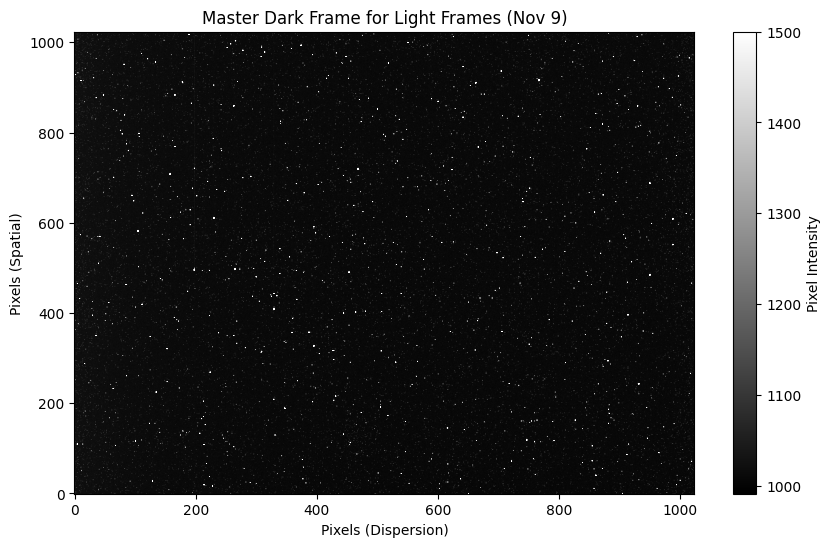

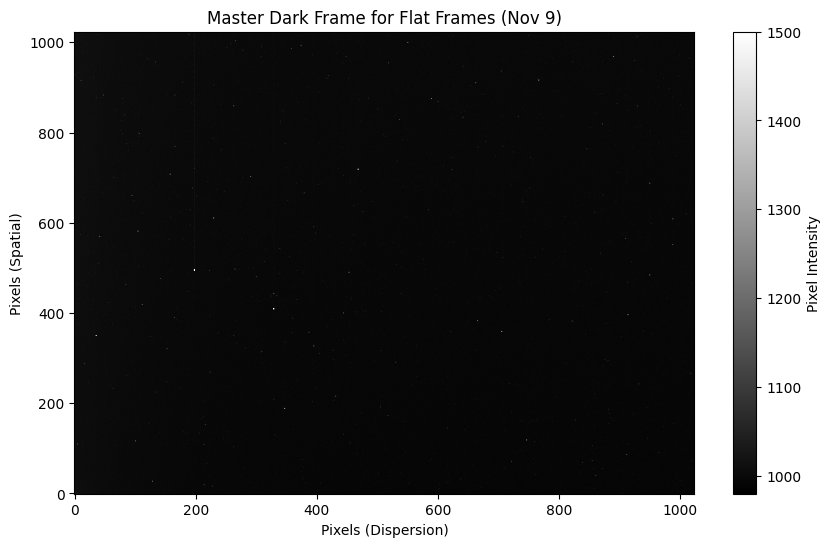

In [45]:
# Cell 16

def create_master_dark(dark_frame_light_template_3, dark_frame_flat_template_3):
    """
    Create a master dark frame by median-combining the dark frames, and output the graph of the master 
    dark field with a maximum value of 9000.

    :param dark_frames: List of tuples containing headers and data for the dark FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type dark_frames: list of tuples
    :return: Master dark frame after bias subtraction.
    :rtype: np.ndarray
    """

    # dark_frames: A list of tuples containing headers and data for each dark frame. 
    # Each tuple has a FITS header and a 2D numpy array (data).
    # Create the master dark frame by median-combining the dark frames
    dark_light_data_list_3 = [frame[1] for frame in dark_frame_light_template_3]  # Extract the 'data' part from each dark frame
    dark_flat_data_list_3 = [frame[1] for frame in dark_frame_flat_template_3]
    master_dark_l_3 = np.median(np.array(dark_light_data_list_3), axis=0)
    master_dark_f_3 = np.median(np.array(dark_flat_data_list_3), axis=0)

    # Extracts the data (2D numpy arrays) from each tuple in dark_frames.
    # Stacks these arrays into a 3D array using np.stack and calculates the median across the stack along the specified axis (axis=0), 
    # which computes the median for each pixel.
    # This process effectively reduces random noise and outliers, such as cosmic ray hits, in the combined master dark frame.

    # Filter the master dark frame
    # master_dark_l[master_dark_l > 9000] = 9000  
    # Clamp values above 9000
    # master_dark_f[master_dark_f > 9000] = 9000
    # Plotting the master dark frame with a maximum value of 9000
    

    # Plotting the master dark for light frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_l_3, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Light Frames (Nov 9)')
    plt.grid(False)
    plt.show()
    
    # Plotting the master dark for flat frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_f_3, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Flat Frames (Nov 9)')
    plt.grid(False)
    plt.show()

    return master_dark_l_3, master_dark_f_3


# Example call to the function after loading data correctly

# Load the dark frames using read_fits_range
dark_frame_light_3 = read_fits_range(dark_frame_light_template_3, dark_frame_light_start_index_3, dark_frame_light_end_index_3)
dark_frame_flat_3 = read_fits_range(dark_frame_flat_template_3, dark_frame_flat_start_index_3, dark_frame_flat_end_index_3)

master_dark_l_3, master_dark_f_3 = create_master_dark(dark_frame_light_3, dark_frame_flat_3)

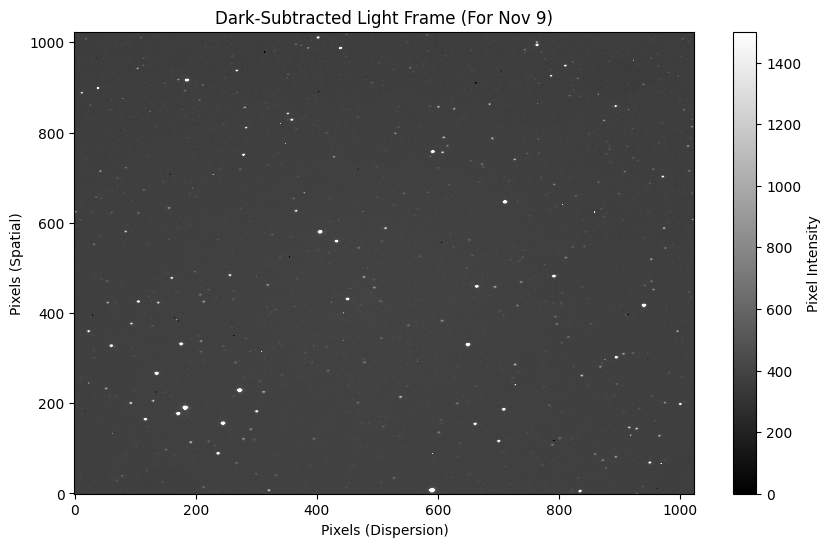

Master Dark Min: 991.0, Max: 61336.5
Light Frame (Before Subtraction) Min: 1290, Max: 64987
Light Frame (After Subtraction) Min: -7302.0, Max: 63960.5


In [47]:
# Cell 17

def subtract_master_dark(frames, master_dark): #, clip_min=0):
    """
    Subtract the master dark frame from each frame in a list of FITS frames and optionally clip negative values.

    :param frames: List of tuples containing headers and data for each FITS frame (light or flat frames).
                   Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type frames: list of tuples
    :param master_dark: Master dark frame to subtract from each frame's data.
    :type master_dark: np.ndarray
    :param clip_min: Minimum value for pixel intensity to avoid negative values (default is 0).
    :type clip_min: float
    :return: List of tuples with headers and dark-subtracted (and optionally clipped) data for each frame.
    :rtype: list of tuples
    """
    subtracted_frames = []
    for header, data in frames:
        # Perform dark subtraction
        subtracted_data = data - master_dark
        
        # Clip values below clip_min
        # subtracted_data = np.maximum(subtracted_data, clip_min)
        
        subtracted_frames.append((header, subtracted_data))
    return subtracted_frames



# Load the light and flat frames
light_frames_3 = read_fits_range(light_frame_template_3, light_frame_start_index_3, light_frame_end_index_3)
flat_frames_3 = read_fits_range(flat_frame_template_3, flat_frame_start_index_3, flat_frame_end_index_3)

# Subtract the master dark frames
light_frames_dark_subtracted_3 = subtract_master_dark(light_frames_3, master_dark_l_3)
flat_frames_dark_subtracted_3 = subtract_master_dark(flat_frames_3, master_dark_f_3)

# Example: Display one of the dark-subtracted light frames
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_dark_subtracted_3[0][1], cmap='gray', origin='lower', aspect='auto', vmin=0, vmax =1500)
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Dark-Subtracted Light Frame (For Nov 9)')
plt.grid(False)
plt.show()

# Debugging: Inspect the range of pixel values
print(f"Master Dark Min: {master_dark_l_3.min()}, Max: {master_dark_l_3.max()}")
print(f"Light Frame (Before Subtraction) Min: {light_frames_3[0][1].min()}, Max: {light_frames_3[0][1].max()}")
print(f"Light Frame (After Subtraction) Min: {light_frames_dark_subtracted_3[0][1].min()}, Max: {light_frames_dark_subtracted_3[0][1].max()}")

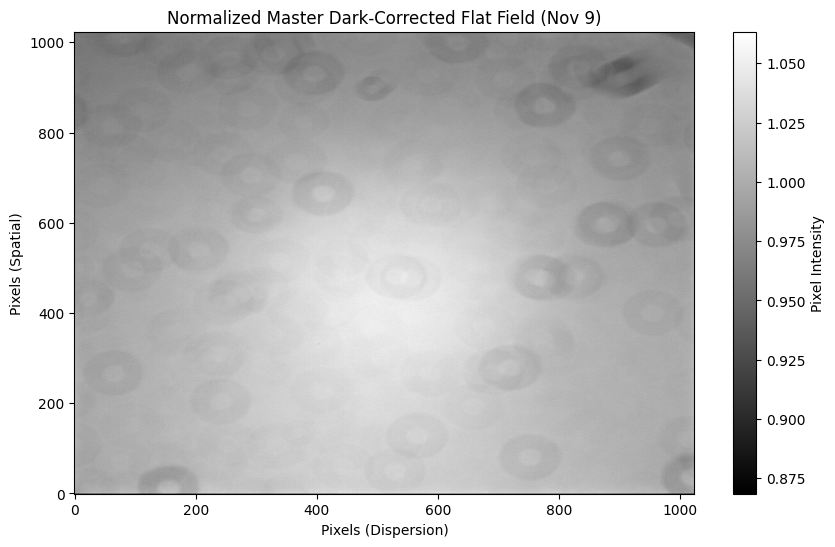

In [19]:
# Cell 18

def dark_corrected_flat_3(flat_frames_dark_subtracted_3):
    """
    Plot a dark-corrected and normalized flat field to show the intensity distribution.

    :param flat_frames_dark_subtracted: List of tuples with headers and dark-corrected flat field data.
                                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type flat_frames_dark_subtracted: list of tuples
    """
    # Directly combine dark-subtracted flat frames to create a master flat
    master_flat_3 = np.median(np.stack([frame[1] for frame in flat_frames_dark_subtracted_3]), axis=0)

    # Calculate the mode of the master flat's flattened data
    mode_value_3 = stats.mode(master_flat_3.flatten(), keepdims=True)[0][0]

    # Normalize the master flat by dividing by the mode value
    normalized_master_flat_3 = master_flat_3 / mode_value_3

    # Plot the normalized master dark-corrected flat field
    plt.figure(figsize=(10, 6))
    plt.imshow(normalized_master_flat_3, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Normalized Master Dark-Corrected Flat Field (Nov 9)')
    plt.grid(False)
    plt.show()
    
    return normalized_master_flat_3

# Example call to plot function
normalized_master_flat_3 = dark_corrected_flat_3(flat_frames_dark_subtracted_3)

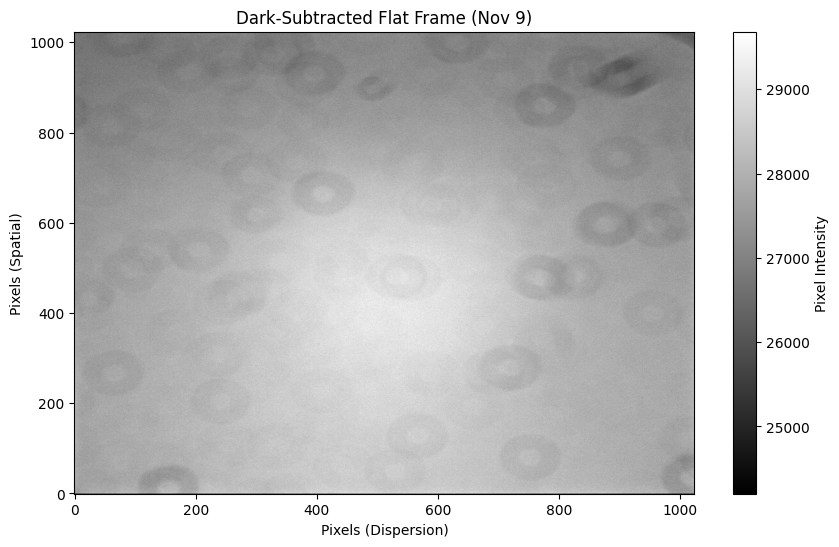

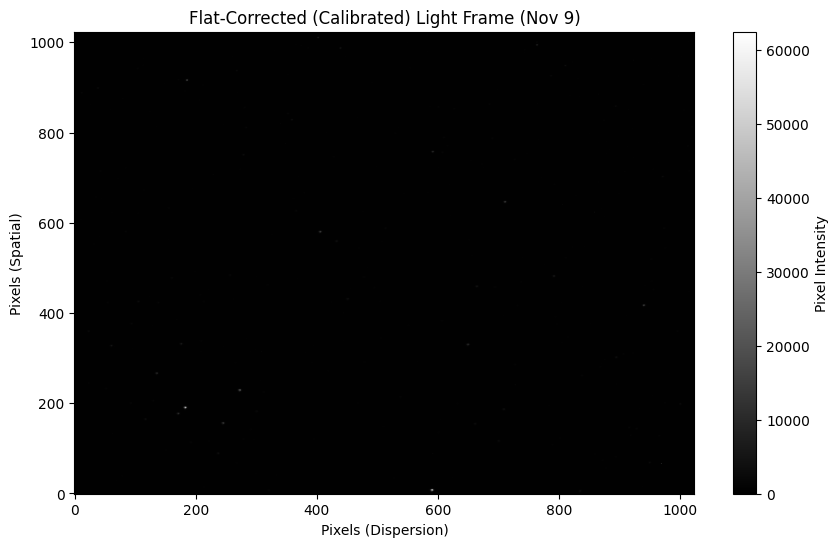

In [20]:
# Cell 19

def master_flat_light(light_frames_dark_subtracted, master_flat):
    """
    Apply master flat field correction to dark-corrected light frames using a mode-normalized master flat.

    :param light_frames_dark_subtracted: List of tuples with headers and dark-corrected light frame data.
                                         Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type light_frames_dark_subtracted: list of tuples
    :param master_flat: Master flat field for flat field correction.
    :type master_flat: np.ndarray
    :return: List of tuples with headers and flat-corrected light frame data.
    :rtype: list of tuples
    """
    # Calculate the mode of the master flat and normalize it
    # mode_value = stats.mode(master_flat.flatten(), keepdims=True)[0][0]
    # normalized_master_flat = master_flat / mode_value

    # Apply the normalized master flat to each dark-corrected light frame
    flat_corrected_frames = []
    for header, data in light_frames_dark_subtracted:
        # Apply flat correction by dividing each pixel by the normalized master flat
        corrected_data = data / normalized_master_flat
        flat_corrected_frames.append((header, corrected_data))
    
    return flat_corrected_frames

# Assuming you've already created the master flat field from the flat frames
flat_frames_dark_subtracted_3 = subtract_master_dark(flat_frames_3, master_dark_f_3)
master_flat_3 = np.median([frame[1] for frame in flat_frames_dark_subtracted_3], axis=0)

# Apply the master flat field to the dark-subtracted light frames
light_frames_flat_corrected_3 = master_flat_light(light_frames_dark_subtracted_3, master_flat_3)

# Plot one of the dark-subtracted flat frames
plt.figure(figsize=(10, 6))
plt.imshow(flat_frames_dark_subtracted_3[0][1], cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Dark-Subtracted Flat Frame (Nov 9)')
plt.grid(False)
plt.show()

# Plot one of the flat-corrected light frames
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_flat_corrected_3[0][1], cmap='gray', origin='lower', aspect='auto', vmin=0)
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Flat-Corrected (Calibrated) Light Frame (Nov 9)')
plt.grid(False)
plt.show()

In [21]:
# Cell 20

def save_flat_corrected_frames_individually_3(flat_corrected_frames, save_directory=r"..\FITS_Files_Corrected\Nov_9_XX_Cyg"):
    
    # Save each flat-corrected light frame as an individual FITS file in the specified directory.

    # :param flat_corrected_frames: List of tuples with headers and flat-corrected light frame data.
                                #  Each tuple has the format (header, data), where `data` is a 2D numpy array.
    # :type flat_corrected_frames: list of tuples
    # :param save_directory: Directory where the individual flat-corrected frames will be saved.
    # :type save_directory: str
    
    # Ensure the save directory exists
    os.makedirs(save_directory, exist_ok=True)
    
    for i, (header, data) in enumerate(flat_corrected_frames):
        # Define the filename for each frame based on its index
        filename = os.path.join(save_directory, f"flat_corrected_frame_3_{i:04d}.fits")
        
        # Create a new FITS HDU with the corrected data and the original header
        hdu = fits.PrimaryHDU(data=data, header=header)
        
        # Write the FITS file to disk
        hdu.writeto(filename, overwrite=True)
        
        print(f"Saved {filename}")

# Example usage
save_flat_corrected_frames_individually_3(light_frames_flat_corrected_3, save_directory=r"..\FITS_Files_Corrected\Nov_9_XX_Cyg")


Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0000.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0001.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0002.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0003.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0004.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0005.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0006.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0007.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0008.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0009.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0010.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0011.fits
Saved ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0012.fits
Saved ..\FIT

In [15]:
# 4.2

ast = AstrometryNet()
ast.api_key = keyring.get_password('astroquery:astrometry_net', 'username')

In [ ]:
# For Nov_5_DY_Peg

# Initialize the AstrometryNet class and set the API key
ast = AstrometryNet()
ast.api_key = 'lhtjfjrgllrbebjp'

# Define the file path template and number of files
file_template = r"..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_{i:04d}.fits"
num_files = 240  # Total number of files

# Directory to save WCS-corrected files
output_directory = r"..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS"
os.makedirs(output_directory, exist_ok=True)

# List of frames to exclude
exclude_frames = list(range(67, 72)) + [122]

# Loop through all files and solve for WCS
for i in range(num_files):
    if i in exclude_frames:
        print(f"Skipping frame {i:04d}")
        continue  # Skip the excluded frames
    
    file_path = file_template.format(i=i)
    try:
        print(f"Processing file: {file_path}")
        
        # Solve for WCS
        wcs_header = ast.solve_from_image(file_path, force_image_upload=True)
        
        # Read the original FITS file to get the data
        with fits.open(file_path) as hdul:
            original_data = hdul[0].data  # Get the image data
        
        # Create a new FITS HDU with the original data and the WCS header
        hdu = fits.PrimaryHDU(data=original_data, header=wcs_header)
        
        # Define the output file path
        output_path = os.path.join(output_directory, f"wcs_corrected_frame_{i:04d}.fits")
        
        # Write the WCS-corrected FITS file
        hdu.writeto(output_path, overwrite=True)

        print(f"Saved WCS-corrected file: {output_path}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")


Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0000.fits
Solving.............Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0000.fits
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0001.fits
Solving.............Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0001.fits
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0002.fits
Solving.............Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0002.fits
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0003.fits
Solving...........Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0003.fits
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0004.fits
Solving............Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_000

KeyboardInterrupt: 

In [20]:
wcs_header

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        347.188883541 / RA  of reference point                         
CRVAL2  =        17.2570883573 / DEC of reference point                         
CRPIX1  =        356.5169181

In [34]:
# For Nov_5_DY_Peg

# Directory to save the extracted flux and coordinate results
results_directory = r"..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results"
os.makedirs(results_directory, exist_ok=True)

# Parameters for source detection
threshold_sigma = 2.0  # Detection threshold in sigma
npixels = 5  # Minimum number of connected pixels above the threshold
gaussian_stddev = 2  # Standard deviation for Gaussian kernel

# Create a Gaussian kernel for convolution
gaussian_kernel = Gaussian2DKernel(gaussian_stddev)

# Loop through all files
for i in range(num_files):
    if i in exclude_frames:
        print(f"Skipping frame {i:04d}")
        continue  # Skip the excluded frames
    
    file_path = file_template.format(i=i)
    try:
        print(f"Processing file: {file_path}")
        
        # Solve for WCS
        wcs_header = ast.solve_from_image(file_path, force_image_upload=True)
        
        # Read the original FITS file to get the data
        with fits.open(file_path) as hdul:
            original_data = hdul[0].data  # Get the image data
            header = hdul[0].header
        
        # Combine the WCS header with the existing header
        for key, value in wcs_header.items():
            header[key] = value
        
        # Create WCS object
        wcs = WCS(header)

        # Apply Gaussian smoothing
        smoothed_data = convolve(original_data, gaussian_kernel, normalize_kernel=True)

        # Calculate the detection threshold
        mean, median, std = sigma_clipped_stats(smoothed_data, sigma=3.0)
        threshold = median + (threshold_sigma * std)

        # Detect sources in the image
        segmentation_map = detect_sources(smoothed_data, threshold, npixels=npixels)

        # Create the source catalog
        catalog = SourceCatalog(original_data, segmentation_map, wcs=wcs)

        # Extract source properties
        source_fluxes = catalog.segment_flux  # Correct attribute for source flux
        source_coordinates = catalog.sky_centroid  # RA and Dec for each source

        # Save results to a file
        results_path = os.path.join(results_directory, f"source_catalog_frame_{i:04d}.txt")
        with open(results_path, "w") as f:
            f.write("# Source Fluxes and Coordinates\n")
            f.write("# Flux (e-/s), RA (deg), Dec (deg)\n")
            for flux, coord in zip(source_fluxes, source_coordinates):
                ra, dec = coord.ra.deg, coord.dec.deg
                f.write(f"{flux:.3f}, {ra:.6f}, {dec:.6f}\n")
        
        print(f"Saved source catalog to {results_path}")

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")


Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0000.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0000.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0001.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0001.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0002.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0002.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0003.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0003.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0004.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0004.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0005.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0005.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0006.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0006.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0007.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0007.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0008.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0008.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0009.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0009.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0010.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0010.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0011.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0011.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0012.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0012.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0013.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0013.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0014.fits
Solving......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0014.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0015.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0015.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0016.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0016.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0017.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0017.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0018.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0018.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0019.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0019.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0020.fits
Solving....

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0020.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0021.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0021.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0022.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0022.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0023.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0023.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0024.fits
Solving........................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0024.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0025.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0025.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0026.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0026.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0027.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0027.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0028.fits
Solving.....

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0028.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0029.fits
Solving.........................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0029.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0030.fits
Solving....................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0030.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0031.fits
Solving.....................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0031.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0032.fits
Solving.......................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0032.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0033.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0033.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0034.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0034.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0035.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0035.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0036.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0036.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0037.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0037.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0038.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0038.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0039.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0039.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0040.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0040.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0041.fits
Solving......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0041.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0042.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0042.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0043.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0043.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0044.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0044.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0045.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0045.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0046.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0046.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0047.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0047.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0048.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0048.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0049.fits
Solving....

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0049.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0050.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0050.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0051.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0051.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0052.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0052.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0053.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0053.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0054.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0054.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0055.fits
Solving..................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0055.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0056.fits
Solving...................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0056.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0057.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0057.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0058.fits
Solving....................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0058.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0059.fits
Solving....................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0059.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0060.fits
Solving.......................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0060.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0061.fits
Solving..................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0061.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0062.fits
Solving...........................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0062.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0063.fits
Solving..........................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0063.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0064.fits
Solving............................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0064.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0065.fits
Solving...................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0065.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0066.fits
Solving..............................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0066.txt
Skipping frame 0067
Skipping frame 0068
Skipping frame 0069
Skipping frame 0070
Skipping frame 0071
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0072.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0072.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0073.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0073.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0074.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0074.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0075.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0075.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0076.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0076.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0077.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0077.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0078.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0078.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0079.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0079.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0080.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0080.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0081.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0081.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0082.fits
Solving......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0082.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0083.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0083.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0084.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0084.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0085.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0085.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0086.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0086.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0087.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0087.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0088.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0088.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0089.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0089.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0090.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0090.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0091.fits
Solving......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0091.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0092.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0092.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0093.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0093.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0094.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0094.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0095.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0095.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0096.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0096.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0097.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0097.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0098.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0098.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0099.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0099.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0100.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0100.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0101.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0101.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0102.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0102.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0103.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0103.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0104.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0104.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0105.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0105.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0106.fits
Solving......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0106.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0107.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0107.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0108.fits
Solving.........................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0108.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0109.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0109.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0110.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0110.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0111.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0111.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0112.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0112.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0113.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0113.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0114.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0114.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0115.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0115.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0116.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0116.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0117.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0117.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0118.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0118.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0119.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0119.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0120.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0120.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0121.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0121.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0122.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0122.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0123.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0123.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0124.fits
Solving.......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0124.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0125.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0125.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0126.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0126.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0127.fits
Solving..................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0127.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0128.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0128.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0129.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0129.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0130.fits
Solving.................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0130.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0131.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0131.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0132.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0132.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0133.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0133.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0134.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0134.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0135.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0135.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0136.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0136.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0137.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0137.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0138.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0138.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0139.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0139.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0140.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0140.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0141.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0141.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0142.fits
Solving.......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0142.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0143.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0143.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0144.fits
Solving......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0144.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0145.fits
Solving.......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0145.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0146.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0146.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0147.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0147.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0148.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0148.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0149.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0149.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0150.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0150.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0151.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0151.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0152.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0152.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0153.fits
Solving....

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0153.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0154.fits
Solving........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0154.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0155.fits
Solving.......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0155.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0156.fits
Solving...

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0156.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0157.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0157.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0158.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0158.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0159.fits
Solving.............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0159.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0160.fits
Solving..........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0160.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0161.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0161.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0162.fits
Solving...............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0162.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0163.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0163.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0164.fits
Solving.................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0164.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0165.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0165.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0166.fits
Solving...................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0166.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0167.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0167.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0168.fits
Solving.................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0168.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0169.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0169.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0170.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0170.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0171.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0171.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0172.fits
Solving..................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0172.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0173.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0173.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0174.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0174.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0175.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0175.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0176.fits
Solving..................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0176.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0177.fits
Solving....Error processing file ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0177.fits: HTTPConnectionPool(host='nova.astrometry.net', port=80): Max retries exceeded with url: /api/submissions/11208523 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000253D5A3F440>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0178.fits
Error processing file ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0178.fits: HTTPConnectionPool(host='nova.astrometry.net', port=80): Max retries exceeded with url: /api/upload (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000253FFC036B0>: Failed to establish a new connection: [Errno 11001] 

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0228.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0229.fits
Solving..................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0229.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0230.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0230.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0231.fits
Solving.........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0231.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0232.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0232.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0233.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0233.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0234.fits
Solving.....

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0234.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0235.fits
Solving.......

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0235.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0236.fits
Solving...........

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0236.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0237.fits
Solving..............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0237.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0238.fits
Solving................

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0238.txt
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg\flat_corrected_frame_0239.fits
Solving............

Saved source catalog to ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Results\source_catalog_frame_0239.txt


In [29]:
from astropy.io import fits
from astropy.wcs import WCS
import os


ast = AstrometryNet()
ast.api_key = 'lhtjfjrgllrbebjp'


def store_wcs_headers(file_template, num_files, exclude_frames, output_path):
    """
    Store WCS headers from FITS files into a single FITS file.

    :param file_template: Template for the FITS file paths with placeholders for file indices.
    :type file_template: str
    :param num_files: Total number of files to process.
    :type num_files: int
    :param exclude_frames: List of frame indices to exclude from processing.
    :type exclude_frames: list
    :param output_path: Path to save the combined WCS headers FITS file.
    :type output_path: str
    """
    # Initialize a list to store HDUs
    hdu_list = [fits.PrimaryHDU()]  # Primary HDU for compliance

    for i in range(num_files):
        if i in exclude_frames:
            print(f"Skipping frame {i:04d}")
            continue
        
        file_path = file_template.format(i=i)
        try:
            print(f"Processing file: {file_path}")
            
            # Solve for WCS
            wcs_header = ast.solve_from_image(file_path, force_image_upload=True)
            
            # Convert WCS header to an Astropy WCS object
            wcs = WCS(wcs_header)
            
            # Create a new HDU for the WCS header
            hdu = fits.ImageHDU(header=wcs.to_header(), name=f"WCS_FRAME_{i:04d}")
            hdu_list.append(hdu)
            
            print(f"WCS header for frame {i:04d} added to the list")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Write all WCS headers to a single FITS file
    hdul = fits.HDUList(hdu_list)
    hdul.writeto(output_path, overwrite=True)
    print(f"Stored all WCS headers in {output_path}")

# Example usage
file_template = r"..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_{i:04d}.fits"
num_files = 240
exclude_frames = [67, 68, 69, 70, 71, 210]
output_path = r"..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS_Headers.fits"

store_wcs_headers(file_template, num_files, exclude_frames, output_path)


Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0000.fits
Solving.................WCS header for frame 0000 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0001.fits
Solving...........WCS header for frame 0001 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0002.fits
Solving.......WCS header for frame 0002 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0003.fits
Solving..........WCS header for frame 0003 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0004.fits
Solving............WCS header for frame 0004 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0005.fits
Solving.......WCS header for frame 0005 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_5_DY_Peg_WCS\wcs_corrected_frame_0006.fits
Solving.......

In [25]:
#For Nov_7_CY_Aqr

# Initialize the AstrometryNet class and set the API key
ast = AstrometryNet()
ast.api_key = 'lhtjfjrgllrbebjp'

# Define the file path template and number of files
file_template = r"..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_{i:04d}.fits"
num_files = 240  # Total number of files

# Directory to save WCS-corrected files
output_directory = r"..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS"
os.makedirs(output_directory, exist_ok=True)

# List of frames to exclude
# exclude_frames = list(range(181,199)) 

# Loop through all files and solve for WCS
for i in range(num_files):
    if i in exclude_frames:
        print(f"Skipping frame {i:04d}")
        continue  # Skip the excluded frames
    
    file_path = file_template.format(i=i)
    try:
        print(f"Processing file: {file_path}")
        
        # Solve for WCS
        wcs_header = ast.solve_from_image(file_path, force_image_upload=True)
        
        # Read the original FITS file to get the data
        with fits.open(file_path) as hdul:
            original_data = hdul[0].data  # Get the image data
        
        # Create a new FITS HDU with the original data and the WCS header
        hdu = fits.PrimaryHDU(data=original_data, header=wcs_header)
        
        # Define the output file path
        output_path = os.path.join(output_directory, f"wcs_corrected_frame_{i:04d}.fits")
        
        # Write the WCS-corrected FITS file
        hdu.writeto(output_path, overwrite=True)

        print(f"Saved WCS-corrected file: {output_path}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")



Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0000.fits
Solving.........................................................................................Error processing file ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0000.fits: ('Solve timed out without success or failure', 11219099)
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0001.fits
Solving...................................................................................Error processing file ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0001.fits: ('Solve timed out without success or failure', 11219107)
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr\flat_corrected_frame_2_0002.fits
Solving............................

KeyboardInterrupt: 

In [ ]:
#For Nov_7_CY_Aqr

# Directory to save the extracted flux and coordinate results
results_directory = r"..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS_Results"
os.makedirs(results_directory, exist_ok=True)

# Parameters for source detection
threshold_sigma = 2.0  # Detection threshold in sigma
npixels = 5  # Minimum number of connected pixels above the threshold
gaussian_stddev = 2  # Standard deviation for Gaussian kernel

# Create a Gaussian kernel for convolution
gaussian_kernel = Gaussian2DKernel(gaussian_stddev)

# Loop through all files
for i in range(num_files):
    if i in exclude_frames:
        print(f"Skipping frame {i:04d}")
        continue  # Skip the excluded frames
    
    file_path = file_template.format(i=i)
    try:
        print(f"Processing file: {file_path}")
        
        # Solve for WCS
        wcs_header = ast.solve_from_image(file_path, force_image_upload=True)
        
        # Read the original FITS file to get the data
        with fits.open(file_path) as hdul:
            original_data = hdul[0].data  # Get the image data
            header = hdul[0].header
        
        # Combine the WCS header with the existing header
        for key, value in wcs_header.items():
            header[key] = value
        
        # Create WCS object
        wcs = WCS(header)

        # Apply Gaussian smoothing
        smoothed_data = convolve(original_data, gaussian_kernel, normalize_kernel=True)

        # Calculate the detection threshold
        mean, median, std = sigma_clipped_stats(smoothed_data, sigma=3.0)
        threshold = median + (threshold_sigma * std)

        # Detect sources in the image
        segmentation_map = detect_sources(smoothed_data, threshold, npixels=npixels)

        # Create the source catalog
        catalog = SourceCatalog(original_data, segmentation_map, wcs=wcs)

        # Extract source properties
        source_fluxes = catalog.segment_flux  # Correct attribute for source flux
        source_coordinates = catalog.sky_centroid  # RA and Dec for each source

        # Save results to a file
        results_path = os.path.join(results_directory, f"source_catalog_frame_{i:04d}.txt")
        with open(results_path, "w") as f:
            f.write("# Source Fluxes and Coordinates\n")
            f.write("# Flux (e-/s), RA (deg), Dec (deg)\n")
            for flux, coord in zip(source_fluxes, source_coordinates):
                ra, dec = coord.ra.deg, coord.dec.deg
                f.write(f"{flux:.3f}, {ra:.6f}, {dec:.6f}\n")
        
        print(f"Saved source catalog to {results_path}")

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")


NameError: name 'num_files' is not defined

In [ ]:
from astropy.io import fits
from astropy.wcs import WCS
import os
from astroquery.astrometry_net import AstrometryNet

# Initialize the AstrometryNet class
ast = AstrometryNet()
ast.api_key = 'lhtjfjrgllrbebjp'

def store_headers_and_wcs(file_template, num_files, exclude_frames, output_path):
    """
    Store WCS headers and original headers from FITS files into a single FITS file.

    :param file_template: Template for the FITS file paths with placeholders for file indices.
    :type file_template: str
    :param num_files: Total number of files to process.
    :type num_files: int
    :param exclude_frames: List of frame indices to exclude from processing.
    :type exclude_frames: list
    :param output_path: Path to save the combined headers FITS file.
    :type output_path: str
    """
    # Initialize a list to store HDUs
    hdu_list = [fits.PrimaryHDU()]  # Primary HDU for compliance

    for i in range(num_files):
        if i in exclude_frames:
            print(f"Skipping frame {i:04d}")
            continue

        file_path = file_template.format(i=i)
        try:
            print(f"Processing file: {file_path}")

            # Solve for WCS
            wcs_header = ast.solve_from_image(file_path, force_image_upload=True)

            # Read the original FITS file to get the original header
            with fits.open(file_path) as hdul:
                original_header = hdul[0].header

            # Convert WCS header to an Astropy WCS object
            wcs = WCS(wcs_header)

            # Create HDUs for the original header and WCS header
            original_hdu = fits.ImageHDU(header=original_header, name=f"ORIGINAL_HEADER_{i:04d}")
            wcs_hdu = fits.ImageHDU(header=wcs.to_header(), name=f"WCS_HEADER_{i:04d}")
            
            # Add the HDUs to the list
            hdu_list.append(original_hdu)
            hdu_list.append(wcs_hdu)

            print(f"Headers for frame {i:04d} added to the list")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Write all headers to a single FITS file
    hdul = fits.HDUList(hdu_list)
    hdul.writeto(output_path, overwrite=True)
    print(f"Stored all headers in {output_path}")

# Example usage
file_template = r"..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corrected_frame_{i:04d}.fits"
num_files = 200
exclude_frames = [] #[181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]
output_path = r"..\FITS_Files_Corrected\Nov_7_CY_Aqr_All_Headers.fits"

store_headers_and_wcs(file_template, num_files, exclude_frames, output_path)


Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corrected_frame_0000.fits
Solving..........

Headers for frame 0000 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corrected_frame_0001.fits
Solving.............Headers for frame 0001 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corrected_frame_0002.fits
Solving.........Headers for frame 0002 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corrected_frame_0003.fits
Solving...........Headers for frame 0003 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corrected_frame_0004.fits
Solving...........Headers for frame 0004 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corrected_frame_0005.fits
Solving...........Headers for frame 0005 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corrected_frame_0006.fits
Solving......................Headers for frame 0006 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_7_CY_Aqr_WCS\wcs_corr

In [30]:
#For NOV_9_XX_Cyg

# Initialize the AstrometryNet class and set the API key
ast = AstrometryNet()
ast.api_key = 'lhtjfjrgllrbebjp'

# Define the file path template and number of files
file_template = r"..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_{i:04d}.fits"
num_files = 349  # Total number of files

# Directory to save WCS-corrected files
output_directory = r"..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS"
os.makedirs(output_directory, exist_ok=True)

# List of frames to exclude
exclude_frames = list(range(339,349)) + [35] +[250]

# Loop through all files and solve for WCS
for i in range(num_files):
    if i in exclude_frames:
        print(f"Skipping frame {i:04d}")
        continue  # Skip the excluded frames
    
    file_path = file_template.format(i=i)
    try:
        print(f"Processing file: {file_path}")
        
        # Solve for WCS
        wcs_header = ast.solve_from_image(file_path, force_image_upload=True)
        
        # Read the original FITS file to get the data
        with fits.open(file_path) as hdul:
            original_data = hdul[0].data  # Get the image data
        
        # Create a new FITS HDU with the original data and the WCS header
        hdu = fits.PrimaryHDU(data=original_data, header=wcs_header)
        
        # Define the output file path
        output_path = os.path.join(output_directory, f"wcs_corrected_frame_{i:04d}.fits")
        
        # Write the WCS-corrected FITS file
        hdu.writeto(output_path, overwrite=True)

        print(f"Saved WCS-corrected file: {output_path}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0000.fits
Solving...........Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0000.fits
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0001.fits
Solving.........Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0001.fits
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0002.fits
Solving..........Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0002.fits
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0003.fits
Solving............Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0003.fits
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg\flat_corrected_frame_3_0004.fits
Solving..............Saved WCS-corrected file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame

In [ ]:
#For Nov_9_XX_Cyg

# Directory to save the extracted flux and coordinate results
results_directory = r"..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS_Results"
os.makedirs(results_directory, exist_ok=True)

# Parameters for source detection
threshold_sigma = 2.0  # Detection threshold in sigma
npixels = 5  # Minimum number of connected pixels above the threshold
gaussian_stddev = 2  # Standard deviation for Gaussian kernel

# Create a Gaussian kernel for convolution
gaussian_kernel = Gaussian2DKernel(gaussian_stddev)

# Loop through all files
for i in range(num_files):
    if i in exclude_frames:
        print(f"Skipping frame {i:04d}")
        continue  # Skip the excluded frames
    
    file_path = file_template.format(i=i)
    try:
        print(f"Processing file: {file_path}")
        
        # Solve for WCS
        wcs_header = ast.solve_from_image(file_path, force_image_upload=True)
        
        # Read the original FITS file to get the data
        with fits.open(file_path) as hdul:
            original_data = hdul[0].data  # Get the image data
            header = hdul[0].header
        
        # Combine the WCS header with the existing header
        for key, value in wcs_header.items():
            header[key] = value
        
        # Create WCS object
        wcs = WCS(header)

        # Apply Gaussian smoothing
        smoothed_data = convolve(original_data, gaussian_kernel, normalize_kernel=True)

        # Calculate the detection threshold
        mean, median, std = sigma_clipped_stats(smoothed_data, sigma=3.0)
        threshold = median + (threshold_sigma * std)

        # Detect sources in the image
        segmentation_map = detect_sources(smoothed_data, threshold, npixels=npixels)

        # Create the source catalog
        catalog = SourceCatalog(original_data, segmentation_map, wcs=wcs)

        # Extract source properties
        source_fluxes = catalog.segment_flux  # Correct attribute for source flux
        source_coordinates = catalog.sky_centroid  # RA and Dec for each source

        # Save results to a file
        results_path = os.path.join(results_directory, f"source_catalog_frame_{i:04d}.txt")
        with open(results_path, "w") as f:
            f.write("# Source Fluxes and Coordinates\n")
            f.write("# Flux (e-/s), RA (deg), Dec (deg)\n")
            for flux, coord in zip(source_fluxes, source_coordinates):
                ra, dec = coord.ra.deg, coord.dec.deg
                f.write(f"{flux:.3f}, {ra:.6f}, {dec:.6f}\n")
        
        print(f"Saved source catalog to {results_path}")

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

In [31]:
ast = AstrometryNet()
ast.api_key = 'lhtjfjrgllrbebjp'

def store_headers_and_wcs(file_template, num_files, exclude_frames, output_path):
    """
    Store WCS headers and original headers from FITS files into a single FITS file.

    :param file_template: Template for the FITS file paths with placeholders for file indices.
    :type file_template: str
    :param num_files: Total number of files to process.
    :type num_files: int
    :param exclude_frames: List of frame indices to exclude from processing.
    :type exclude_frames: list
    :param output_path: Path to save the combined headers FITS file.
    :type output_path: str
    """
    # Initialize a list to store HDUs
    hdu_list = [fits.PrimaryHDU()]  # Primary HDU for compliance

    for i in range(num_files):
        if i in exclude_frames:
            print(f"Skipping frame {i:04d}")
            continue

        file_path = file_template.format(i=i)
        try:
            print(f"Processing file: {file_path}")

            # Solve for WCS
            wcs_header = ast.solve_from_image(file_path, force_image_upload=True)

            # Read the original FITS file to get the original header
            with fits.open(file_path) as hdul:
                original_header = hdul[0].header

            # Convert WCS header to an Astropy WCS object
            wcs = WCS(wcs_header)

            # Create HDUs for the original header and WCS header
            original_hdu = fits.ImageHDU(header=original_header, name=f"ORIGINAL_HEADER_{i:04d}")
            wcs_hdu = fits.ImageHDU(header=wcs.to_header(), name=f"WCS_HEADER_{i:04d}")
            
            # Add the HDUs to the list
            hdu_list.append(original_hdu)
            hdu_list.append(wcs_hdu)

            print(f"Headers for frame {i:04d} added to the list")

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Write all headers to a single FITS file
    hdul = fits.HDUList(hdu_list)
    hdul.writeto(output_path, overwrite=True)
    print(f"Stored all headers in {output_path}")

# Example usage
file_template = r"..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_{i:04d}.fits"
num_files = 349
exclude_frames = [35, 250, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
output_path = r"..\FITS_Files_Corrected\Nov_9_WCS_All_Headers.fits"

store_headers_and_wcs(file_template, num_files, exclude_frames, output_path)


Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0000.fits
Solving..............Headers for frame 0000 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0001.fits
Solving.........Headers for frame 0001 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0002.fits
Solving............Headers for frame 0002 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0003.fits
Solving............Headers for frame 0003 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0004.fits
Solving...........Headers for frame 0004 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0005.fits
Solving...........Headers for frame 0005 added to the list
Processing file: ..\FITS_Files_Corrected\Nov_9_XX_Cyg_WCS\wcs_corrected_frame_0006.fits
Solving...........Headers f